In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import os
import scipy.stats as st
import pickle


from candlestick.candlestick import *

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from getstock import *

matplotlib.rcParams['figure.figsize'] = (14, 6)

# %load_ext autoreload
# %autoreload 2

#### Load data and format it

In [3]:
df_ohlc = pd.read_csv('DAT_MT_USDTRY_M1_201909.csv')
df_ohlc.index = pd.to_datetime(df_ohlc.day)+ pd.to_timedelta(df_ohlc.time.apply(lambda x:x+':00'),unit='minute')
df_ohlc = df_ohlc[['open','high','low','close']]

In [12]:
df_jpy = pd.read_csv('DAT_MT_USDJPY_M1_201909.csv')
df_jpy.index = pd.to_datetime(df_jpy.day)+ pd.to_timedelta(df_jpy.time.apply(lambda x:x+':00'),unit='minute')
df_jpy = df_jpy[['open','high','low','close']]

In [246]:
df_stock1 = pd.read_csv('data1.csv')
df_stock1.index = pd.to_datetime(df_stock1.day)+ pd.to_timedelta(df_stock1.time.apply(lambda x:x+':00'),unit='minute')
# df_stock1 = df_stock1[['open','high','low','close']]

In [3]:
df_stock3 = pd.read_csv('data3.csv')
df_stock3.index = pd.to_datetime(df_stock3.day)+ pd.to_timedelta(df_stock3.time.apply(lambda x:x+':00'),unit='minute')
# df_stock1 = df_stock1[['open','high','low','close']]

In [27]:
df_stock4 = pd.read_csv('data4.csv')
df_stock4.index = pd.to_datetime(df_stock4.day)+ pd.to_timedelta(df_stock4.time.apply(lambda x:x+':00'),unit='minute')
# df_stock1 = df_stock1[['open','high','low','close']]

In [3]:
# df_ohlc = pd.read_csv('NASDAQ_AAPL_5min.csv')
# df_ohlc.index = pd.to_datetime(df_ohlc.date,format="%Y%m%d%H%M")
# df_ohlc = df_ohlc[['open','high','low','close']]

In [29]:
# df_ohlc = pd.read_csv('IBM.1min.TradesAndQuotes.20160128.csv')

# df_ohlc =  df_ohlc[['open','high','low','close']]
# df_ohlc.T

In [238]:
df_stock1.head()

,open,high,low,close
2019-11-20 09:30:00,265.540,265.70,265.06,265.185
2019-11-20 09:31:00,265.154,265.69,265.07,265.575
2019-11-20 09:32:00,265.577,265.96,265.43,265.580
2019-11-20 09:33:00,265.590,265.69,265.37,265.440
2019-11-20 09:34:00,265.440,265.68,265.36,265.600


#### Plot Candlestick chart for a short time

In [239]:
df_to_plot = df_ohlc.iloc[:800]
# df_to_plot = df_stock1.iloc[:800]
# df_to_plot = df_jpy.iloc[:800]
fig = go.Figure(data=[go.Candlestick(x=df_to_plot.index,
                open=df_to_plot['open'],
                high=df_to_plot['high'],
                low=df_to_plot['low'],
                close=df_to_plot['close'])])
fig.show()

#### Define Functions to:
+ Label intervals with returns
+ Detect patterns
+ Make statistics on them

In [6]:
def label(df_candles,n_shift):
    """
    label returns n_shift periods before them
    """
    df_candles['returns'+str(n_shift)] = df_candles['close'].shift(-n_shift)/df_candles['close']
    return df_candles

def get_candlestick_detection_function(pattern):
    return getattr(getattr(__import__('candlestick.candlestick'), 'candlestick'),pattern)

def detect_patterns(patterns_list,df_bars):
    df_bars = df_bars.copy()
    for p in patterns_list:
        func = get_candlestick_detection_function(p)
        df_bars = func(df_bars)
    return df_bars
def make_stats(patterns_list,df_bars,returns_name,confidence=0.95,symbol=None, path_suffix=''):
    df = pd.DataFrame(index=['mean','CI','count','std','significant'])
    ret = (df_bars[returns_name]-1.)*100
    for p in patterns_list:
        p_list = p.split('_')
        p_modified = ''.join(list(map(lambda x: x[0].upper()+x[1:],p_list)))
        ret_pattern = ret[df_bars[p_modified]==True]
        mean= ret_pattern.mean()
        std = ret_pattern.std()
        count = ret_pattern.count()
        CI = std*st.t.ppf(0.5*(1+confidence),count)/np.sqrt(count)
        significant = (mean+CI)*(mean-CI)>0.
        df[p_modified] = [mean,CI,count,std,significant]
        
    n_shift = int(returns_name.split('returns')[-1])
    df_stats =df.T.copy()
    df_stats['n_shift'] = n_shift
    df_stats['confidence'] = confidence
    df_stats['symbol'] =symbol
    df_significant = df_stats[df_stats.significant==True]
    
    if path_suffix == '':
        complete_results_significant(df_significant)
        complete_results_all(symbol,n_shift,df_stats)
    else :
        complete_results_significant(df_significant, path = '_'.join(['stats_res_significant',path_suffix]))
        complete_results_all(symbol,n_shift,df_stats, path = '_'.join(['stats_res',path_suffix]))
    return df 

def label_multi(n_shift_list,df_bars):
    df_bars = df_bars.copy()
    for n in n_shift_list:
        df_bars = label(df_bars,n)
    return df_bars



def dump_pickle(obj, path: str, protocol=pickle.HIGHEST_PROTOCOL):
    """
    :param obj: obj to pickle
    :param path: path for the dump MUST BE with no suffix this function will automatically add '.pickle' in the name
    :param protocol: protocol for the pickling
    """
    f = open(path + '.pickle', 'wb')
    try:
        pickle.dump(obj, f, protocol=protocol)
    except Exception as e:
        raise e
    finally:
        f.close()


def load_pickle(path: str):
    """
    Unpickles an objects, returns it and logs before and after the loading
    :param path: str: path for the file to load
    :return: object of the pickle
    """
    # ensuring the file ends in '.pickle'
    path = path.replace('.pickle', '') + '.pickle'

    print('Unpickling data at {}'.format(path))
    f = open(path, 'rb')
    res = pickle.load(f)
    f.close()
    print('Data unpickled, type: {}'.format(res.__class__))
    return res

def complete_results_all(symbol,n_shift_returns,df_stats, path='stats_results'):
    try:
        dic = load_pickle(path)
    except:
        dic = {}
    
    dic_symbol = dic.get(symbol,{})
    dic_symbol.update({n_shift_returns:df_stats})
    dic.update({symbol:dic_symbol})
    dump_pickle(dic,path)
    
def complete_results_significant(df_stats,path = 'stats_results_significant'):    
    try:
        df = load_pickle(path)
    except:
        df = pd.DataFrame()
    df = pd.concat([df,df_stats])
    df = df.drop_duplicates()

    dump_pickle(df,path)

### Find the list of supported patterns

In [7]:
patterns_list = list(map(lambda x :x.replace('.py',''), os.listdir('candlestick/patterns')))
patterns_list.remove('candlestick_finder')
patterns_list.remove('__pycache__')
patterns_list

['bearish_engulfing',
 'bearish_harami',
 'bullish_engulfing',
 'bullish_harami',
 'dark_cloud_cover',
 'doji',
 'doji_star',
 'dragonfly_doji',
 'evening_star',
 'evening_star_doji',
 'gravestone_doji',
 'hammer',
 'hanging_man',
 'inverted_hammer',
 'morning_star',
 'morning_star_doji',
 'piercing_pattern',
 'rain_drop',
 'rain_drop_doji',
 'shooting_star',
 'star']

#### Run all patterns detection

In [9]:
df_bars = detect_patterns(patterns_list,df_ohlc)

In [10]:
df_bars.head()

,open,high,low,close,BearishEngulfing,BearishHarami,BullishEngulfing,BullishHarami,DarkCloudCover,Doji,...,Hammer,HangingMan,InvertedHammer,MorningStar,MorningStarDoji,PiercingPattern,RainDrop,RainDropDoji,ShootingStar,Star
2019-09-01 17:01:00,5.83330,5.83331,5.83330,5.83331,None,None,None,None,None,False,...,False,None,False,None,None,None,None,None,None,None
2019-09-01 17:02:00,5.83330,5.83330,5.83330,5.83330,False,False,False,False,False,False,...,False,None,False,None,None,False,False,False,False,False
2019-09-01 17:03:00,5.83331,5.83331,5.83330,5.83330,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-09-01 17:04:00,5.83331,5.83331,5.83331,5.83331,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-09-01 17:05:00,5.83330,5.83330,5.83330,5.83330,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Label returns for different shifts

In [191]:
df_bars = label_multi([1,2,3,4,5,8,10,20,30,60],df_bars)

In [20]:
df_bars.tail()

,open,high,low,close,BearishEngulfing,BearishHarami,BullishEngulfing,BullishHarami,DarkCloudCover,Doji,...,returns1,returns2,returns3,returns4,returns5,returns8,returns10,returns20,returns30,returns60
2019-09-30 23:54:00,5.64943,5.64950,5.64924,5.64941,False,False,False,False,False,True,...,0.999979,0.999981,0.999986,0.999993,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-30 23:55:00,5.64947,5.64947,5.64924,5.64929,False,False,False,False,False,False,...,1.000002,1.000007,1.000014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-30 23:56:00,5.64927,5.64943,5.64927,5.64930,False,False,False,False,False,False,...,1.000005,1.000012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-30 23:57:00,5.64940,5.64959,5.64933,5.64933,False,False,False,False,False,False,...,1.000007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-30 23:58:00,5.64933,5.64945,5.64924,5.64937,False,False,False,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Statistics on the returns based on the candlestick pattern

In [192]:
df = make_stats(patterns_list,df_bars,'returns1',confidence=0.95,symbol='USDTRY')
df.T

Unpickling data at stats_results_significant.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_results.pickle
Data unpickled, type: <class 'dict'>


,mean,CI,count,std,significant
BearishEngulfing,0.0012776,0.000995445,1763,0.0213107,True
BearishHarami,-0.000173506,0.000858724,1904,0.0191057,False
BullishEngulfing,-0.000598694,0.00117903,1624,0.024224,False
BullishHarami,-0.000455892,0.000865681,1916,0.0193212,False
DarkCloudCover,0.000930106,0.00719623,24,0.0170814,False
Doji,-8.92527e-05,0.0010527,1474,0.0206038,False
DojiStar,-0.00110093,0.00558534,69,0.0232564,False
DragonflyDoji,-0.0023262,0.00176198,487,0.0197895,True
EveningStar,0.000761088,0.0020088,145,0.0122386,False
EveningStarDoji,-0.00730288,0.045566,2,0.0149768,False


In [140]:
(0.0411/100.+1)**121

1.050977604673014

In [20]:
# dic = load_pickle('stats_results_significant.pickle')
dic = load_pickle('stats_results.pickle')
dic['USDTRY']

Unpickling data at stats_results.pickle
Data unpickled, type: <class 'dict'>


{3:                          mean          CI count         std significant  \
 BearishEngulfing  0.000564763  0.00156173  1763   0.0334338       False   
 BearishHarami      0.00026239  0.00161903  1904   0.0360217       False   
 BullishEngulfing  -0.00181328  0.00173779  1624   0.0357042        True   
 BullishHarami     -0.00114198  0.00151745  1916    0.033868       False   
 DarkCloudCover     0.00854207   0.0143588    24   0.0340829       False   
 Doji               0.00040024  0.00158967  1474   0.0311135       False   
 DojiStar          -0.00150895  0.00783563    69   0.0326263       False   
 DragonflyDoji     -0.00206557  0.00263952   487   0.0296456       False   
 EveningStar       -0.00208222  0.00304921   145   0.0185773       False   
 EveningStarDoji    -0.0120505   0.0213274     2  0.00700997       False   
 GravestoneDoji    0.000393184  0.00154723   744   0.0214975       False   
 Hammer            -0.00598475   0.0061525   201   0.0442363       False   
 HangingM

#### Visualize the distribution of the returns for a specific pattern 

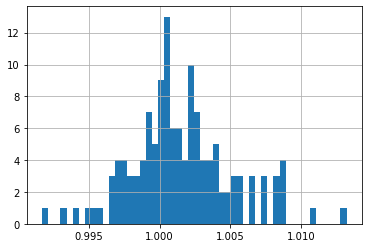

In [33]:
df_bars_stock4['returns60'][df_bars_stock4['Hammer']==True].hist(bins=50)

In [249]:
df_stock1_list = []
for day in df_stock1.day.unique():
    df_stock1_list.append(df_stock1.loc[lambda x: x.day == day])

Unpickling data at stats_results_significant.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_results.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_results_significant.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_results.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_results_significant.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_results.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_results_significant.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_results.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_results_significant.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_results.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_results_significant.pickle
Dat

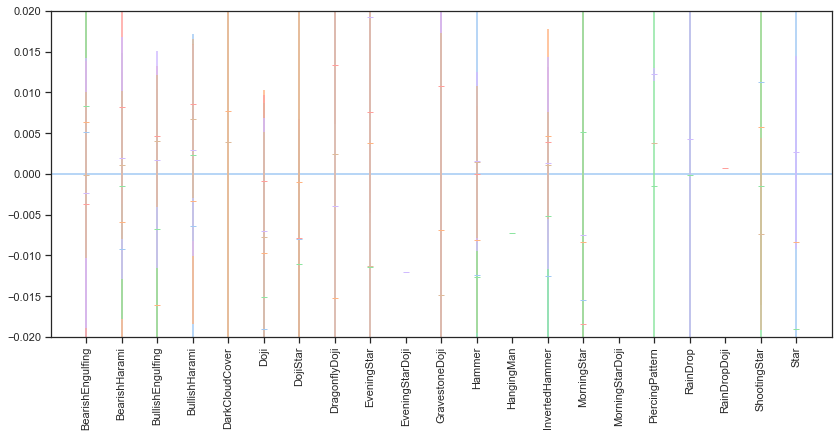

In [252]:
# import matplotlib.pyplot as plt
for df in df_stock1_list:
    aux_bars = detect_patterns(patterns_list,df)
    aux_bars = label_multi([1,2,3,4,5,8,10,20,30,60],aux_bars)
    stats = make_stats(patterns_list,aux_bars,'returns1',confidence=0.95,symbol='USDTRY').T
    plt.errorbar(x=stats.index,y=stats['mean'],yerr=stats['CI'], linestyle='',marker='_')

plt.xticks(rotation='vertical')
plt.axhline(y=0, zorder=0)
plt.ylim(-0.02,0.02)
plt.show()

#### Resample to larger windows

In [ ]:
df_bars = df_bars.resample('2min').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})


### Looking at Persistence over time : 

In [4]:
def compare_time_horizon(df_returns, n_periods=2, n_shifts_list=[1,2,3,4,5,8,10,20,30,60],experiment_name=''):
    N = df_returns.shape[0]
    res = pd.DataFrame(index = patterns_list,
                       columns=pd.MultiIndex.from_tuples([(i,n) for i in range(n_periods) for n in n_shifts_list],
                                                         names=['period', 'shift'])
                      )
    
    for i in range(n_periods):
        for n in n_shifts_list:
            df_stats = make_stats(patterns_list,
                                df_returns.iloc[i*N//n_periods:(i+1)*N//n_periods,:],
                                f'returns{n}',
                                confidence=0.95, 
                                path_suffix=experiment_name+f'_p{i}')
            res[i,n] = [np.sign(x) for x in df_stats.T['mean'].values] 
            res[i,n].where(df_stats.T.significant.values, 0, inplace=True)
    
    return res

In [277]:
test = compare_time_horizon(df_bars_try_ret,experiment_name='try_p2')
test

Unpickling data at stats_res_significant_try_p2_p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_try_p2_p0.pickle
Data unpickled, type: <class 'dict'>


C:\Users\Geof\.conda\envs\algo_trading\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning:

invalid value encountered in sign



Unpickling data at stats_res_significant_try_p2_p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_try_p2_p0.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_try_p2_p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_try_p2_p0.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_try_p2_p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_try_p2_p0.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_try_p2_p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_try_p2_p0.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_try_p2_p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_try_p2_p0.pickle
Data unpickled, type: <class 'di

period               0                                                 1       \
shift               1    2    3    4    5    8    10   20   30   60   1    2    
bearish_engulfing  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0   
bearish_harami     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  0.0  0.0   
bullish_engulfing  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  0.0 -1.0 -1.0 -1.0   
bullish_harami     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
dark_cloud_cover   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
doji               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
doji_star          0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  0.0  0.0  0.0  0.0   
dragonfly_doji     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  0.0   
evening_star       0.0  0.0  0.0  0.0  0.0 -1.0 -1.0  0.0  0.0  0.0  0.0  0.0   
evening_star_doji  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
gravestone_doji    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
hammer            -1.0 -1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0   
hanging_man        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
inverted_hammer    1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0   
morning_star       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
morning_star_doji  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
piercing_pattern   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
rain_drop          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
rain_drop_doji     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
shooting_star      0.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0   
star               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

period                                                     
shift               3    4    5    8    10   20   30   60  
bearish_engulfing  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
bearish_harami     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
bullish_engulfing -1.0 -1.0  0.0  0.0 -1.0 -1.0 -1.0  0.0  
bullish_harami     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
dark_cloud_cover   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
doji               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
doji_star          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
dragonfly_doji     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
evening_star       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
evening_star_doji  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
gravestone_doji    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
hammer             0.0  0.0  0.0  0.0  0.0  0.0 -1.0  0.0  
hanging_man        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
inverted_hammer    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
morning_star       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
morning_star_doji  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
piercing_pattern   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
rain_drop          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
rain_drop_doji     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
shooting_star      0.0  0.0  0.0  0.0  0.0 -1.0  0.0  0.0  
star               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [138]:
# looking at persistence of signals for USD/JPY
jpy_weekly = compare_time_horizon(df_bars_try_ret,n_periods = 4, experiment_name='jpy_p4')
((jpy_weekly[0]==jpy_weekly[1]) & (jpy_weekly[1]==True) & (jpy_weekly[0]==jpy_weekly[2]) & (jpy_weekly[2]==jpy_weekly[3]))

Unpickling data at stats_res_significant_jpy_p4_p0.pickle
Unpickling data at stats_res_jpy_p4_p0.pickle
Unpickling data at stats_res_significant_jpy_p4_p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_jpy_p4_p0.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_jpy_p4_p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_jpy_p4_p0.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_jpy_p4_p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_jpy_p4_p0.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_jpy_p4_p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_jpy_p4_p0.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_jpy_p4_p0.pickle
Data unpickled, type: <class 'pand

shift,1,2,3,4,5,8,10,20,30,60
bearish_engulfing,False,False,False,False,False,False,False,False,False,False
bearish_harami,False,False,False,False,False,False,False,False,False,False
bullish_engulfing,False,False,False,False,False,False,False,False,False,False
bullish_harami,False,False,False,False,False,False,False,False,False,False
dark_cloud_cover,False,False,False,False,False,False,False,False,False,False
doji,False,False,False,False,False,False,False,False,False,False
doji_star,False,False,False,False,False,False,False,False,False,False
dragonfly_doji,False,False,False,False,False,False,False,False,False,False
evening_star,False,False,False,False,False,False,False,False,False,False
evening_star_doji,False,False,False,False,False,False,False,False,False,False


In [141]:
daily_jpy = compare_time_horizon(df_bars_jpy_ret, n_periods=30, n_shifts_list=[1,2,3,4,5,8,10,20,30,60],experiment_name='')

Unpickling data at stats_res_significant__p0.pickle
Unpickling data at stats_res__p0.pickle
Unpickling data at stats_res_significant__p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p0.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p0.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p0.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p0.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p0.pickle


Unpickling data at stats_res_significant__p4.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p4.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p4.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p4.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p4.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p4.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p4.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p4.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p5.pickle
Unpickling data at stats_res__p5.pickle
Unpickling data at stats_res_significant__p5.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p5.pickle


Unpickling data at stats_res_significant__p9.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p9.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p9.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p9.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p9.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p9.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p9.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p9.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p9.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p9.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p9.pickle
Dat

Unpickling data at stats_res_significant__p13.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p13.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p13.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p13.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p14.pickle
Unpickling data at stats_res__p14.pickle
Unpickling data at stats_res_significant__p14.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p14.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p14.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p14.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p14.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_

Unpickling data at stats_res_significant__p18.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p18.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p18.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p18.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p18.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p18.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p18.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p18.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p18.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p18.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p18

Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p22.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p23.pickle
Unpickling data at stats_res__p23.pickle
Unpickling data at stats_res_significant__p23.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p23.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p23.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p23.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p23.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p23.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p23.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p23.pickle
Data unpickled, type: <class 'dict'>
Unpi

Unpickling data at stats_res_significant__p27.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p27.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p27.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p27.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p27.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p27.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p27.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p27.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p27.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p27.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p28

In [28]:
# df_bars_stock1 = detect_patterns(patterns_list,df_stock1)
# df_bars_stock2 = detect_patterns(patterns_list,df_stock2)
# df_bars_stock3 = detect_patterns(patterns_list,df_stock3)
df_bars_stock4 = detect_patterns(patterns_list,df_stock4)

C:\Users\Geof\Documents\Code\algo_trading_project\candlestick\patterns\doji_star.py:25: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Geof\Documents\Code\algo_trading_project\candlestick\patterns\evening_star_doji.py:30: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Geof\Documents\Code\algo_trading_project\candlestick\patterns\star.py:24: RuntimeWarning:

invalid value encountered in double_scalars



In [29]:
df_bars_stock4 = label_multi([1,2,3,4,5,8,10,20,30,60],df_bars_stock4)
# df_bars_stock3 = label_multi([1,2,3,4,5,8,10,20,30,60],df_bars_stock3)
# df_bars_stock2 = label_multi([1,2,3,4,5,8,10,20,30,60],df_bars_stock2)
# df_bars_stock1 = label_multi([1,2,3,4,5,8,10,20,30,60],df_bars_stock1)

In [30]:
daily_stock4 = compare_time_horizon(df_bars_stock4, n_periods=30, n_shifts_list=[1,2,3,4,5,8,10,20,30,60],
                                    experiment_name='stock3')

daily_stock4_count_bear = pd.DataFrame(index = daily_stock4.loc[:,1].index, columns= daily_stock4.loc[:,1].columns,
                               data = np.zeros(daily_stock4.loc[:,1].shape))
daily_stock4_count_bull = pd.DataFrame(index = daily_stock4.loc[:,1].index, columns= daily_stock4.loc[:,1].columns,
                               data = np.zeros(daily_stock4.loc[:,1].shape))

for n in range(30):
    for i in daily_stock4_count_bear.index:
        for j in daily_stock4_count_bear.columns:
            if daily_stock4.loc[i,(n,j)] == 1:
                daily_stock4_count_bull.loc[i,j] += daily_stock4.loc[i,(n,j)]
            if daily_stock4.loc[i,(n,j)] == -1:
                daily_stock4_count_bear.loc[i,j] += 1
            
# daily_stock2_count

Unpickling data at stats_res_significant_stock3_p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p0.pickle
Data unpickled, type: <class 'dict'>


C:\Users\Geof\.conda\envs\algo_trading\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning:

invalid value encountered in sign



Unpickling data at stats_res_significant_stock3_p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p0.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p0.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p0.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p0.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p0.pickle
Data unpickled, type: <class 'di

Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p4.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p4.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p4.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p4.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p4.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p4.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p4.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p4.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p4.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p4.pi

Unpickling data at stats_res_significant_stock3_p8.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p8.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p8.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p8.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p8.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p8.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p8.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p8.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p8.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p8.pickle
Data unpickled, type: <class 'di

Unpickling data at stats_res_significant_stock3_p12.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p12.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p12.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p12.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p12.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p12.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p13.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p13.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p13.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p13.pickle
Data unpickled, type: 

Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p16.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p17.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p17.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p17.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p17.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p17.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p17.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p17.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p17.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_sto

Unpickling data at stats_res_significant_stock3_p21.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p21.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p21.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p21.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p21.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p21.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p21.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p21.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p21.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p21.pickle
Data unpickled, type: 

Unpickling data at stats_res_significant_stock3_p25.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p25.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p25.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p25.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p25.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p25.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p25.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p25.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p25.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p25.pickle
Data unpickled, type: 

Unpickling data at stats_res_significant_stock3_p29.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p29.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p29.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p29.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p29.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p29.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p29.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p29.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_stock3_p29.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_stock3_p29.pickle
Data unpickled, type: 

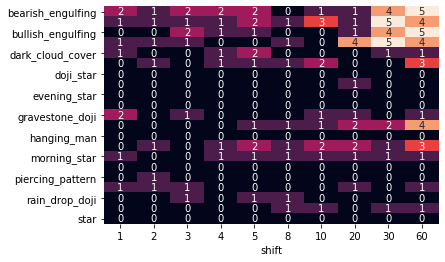

In [20]:
import seaborn as sns
sns.heatmap(daily_stock2_count_bear, annot=True, cmap='rocket', cbar=False, 
#             square=True
           )

In [19]:
(daily_stock2_count_bull+daily_stock2_count_bear).style.background_gradient(cmap='PuBu')

shift,1,2,3,4,5,8,10,20,30,60
bearish_engulfing,4,1,2,3,2,1,2,4,6,12
bearish_harami,1,1,2,2,3,3,6,4,7,10
bullish_engulfing,1,0,3,2,1,0,2,4,8,11
bullish_harami,1,1,1,1,1,4,0,7,10,12
dark_cloud_cover,1,1,3,2,4,2,2,1,1,3
doji,1,1,0,1,1,3,2,3,6,11
doji_star,0,0,0,0,0,0,0,0,0,0
dragonfly_doji,0,0,0,0,0,0,0,1,0,0
evening_star,0,0,0,0,0,0,0,0,0,0
evening_star_doji,0,0,0,0,0,0,0,0,0,0


In [26]:
(daily_stock3_count_bull+daily_stock3_count_bear).style.background_gradient(cmap='PuBu')

shift,1,2,3,4,5,8,10,20,30,60
bearish_engulfing,0,0,3,3,3,5,4,4,6,13
bearish_harami,3,2,3,2,2,5,5,5,3,12
bullish_engulfing,0,0,2,1,1,2,3,6,10,9
bullish_harami,3,0,3,1,1,3,1,1,6,15
dark_cloud_cover,0,1,2,1,1,2,0,1,2,2
doji,3,1,0,2,1,0,5,6,8,14
doji_star,0,0,0,0,0,0,0,1,0,0
dragonfly_doji,0,0,0,0,0,0,0,0,0,0
evening_star,0,0,0,0,0,0,0,0,0,1
evening_star_doji,0,0,0,0,0,0,0,0,0,0


In [31]:
(daily_stock4_count_bull+daily_stock4_count_bear).style.background_gradient(cmap='PuBu')

shift,1,2,3,4,5,8,10,20,30,60
bearish_engulfing,1,0,1,0,0,0,0,1,1,1
bearish_harami,0,0,1,1,1,1,0,2,0,2
bullish_engulfing,1,0,0,0,1,2,2,3,3,2
bullish_harami,1,0,0,1,1,0,0,2,2,1
dark_cloud_cover,0,0,0,0,0,0,0,0,0,0
doji,2,6,5,7,3,4,1,7,5,5
doji_star,0,0,0,0,0,0,0,0,0,0
dragonfly_doji,0,0,0,0,0,0,0,0,0,0
evening_star,0,0,0,0,0,0,0,0,0,0
evening_star_doji,0,0,0,0,0,0,0,0,0,0


In [283]:
daily_stock1 = compare_time_horizon(df_bars_stock1, n_periods=6, n_shifts_list=[1,2,3,4,5,8,10,20,30,60],experiment_name='')

daily_stock1_count = pd.DataFrame(index = daily_stock1.loc[:,1].index, columns= daily_stock1.loc[:,1].columns,
                               data = np.zeros(daily_stock1.loc[:,1].shape))
for n in range(6):
    for i in daily_stock1_count.index:
        for j in daily_stock1_count.columns:
            daily_stock1_count.loc[i,j] += daily_stock1.loc[i,(n,j)]
daily_stock1_count

Unpickling data at stats_res_significant__p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p0.pickle
Data unpickled, type: <class 'dict'>


C:\Users\Geof\.conda\envs\algo_trading\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning:

invalid value encountered in sign



Unpickling data at stats_res_significant__p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p0.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p0.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p0.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p0.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p0.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p0.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p0.pickle
Dat

Unpickling data at stats_res_significant__p4.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p4.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p4.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p4.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p4.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p4.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p4.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p4.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p4.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res__p4.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant__p5.pickle
Dat

shift,1,2,3,4,5,8,10,20,30,60
bearish_engulfing,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0
bearish_harami,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,2.0
bullish_engulfing,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0
bullish_harami,1.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0
dark_cloud_cover,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
doji,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,2.0
doji_star,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
dragonfly_doji,1.0,-1.0,-1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0
evening_star,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
evening_star_doji,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [280]:
daily_stock1_count.style.background_gradient(cmap='PuBu')

shift,1,2,3,4,5,8,10,20,30,60
bearish_engulfing,0,0,0,0,0,1,1,1,1,2
bearish_harami,0,0,0,0,1,0,1,1,2,2
bullish_engulfing,-1,-1,0,0,0,0,0,-1,-1,-1
bullish_harami,1,1,2,1,2,2,2,1,1,2
dark_cloud_cover,0,0,0,0,0,0,0,0,1,1
doji,0,0,0,0,0,0,0,-1,0,2
doji_star,0,-1,0,0,0,0,0,1,1,1
dragonfly_doji,1,-1,-1,0,0,1,0,1,0,2
evening_star,0,0,0,0,0,0,0,0,0,1
evening_star_doji,0,0,0,0,0,0,0,0,0,0


In [243]:
daily_stock1_count.style.background_gradient(cmap='PuBu')

shift,1,2,3,4,5,8,10,20,30,60
bearish_engulfing,3,1,2,4,4,3,4,5,3,15
bearish_harami,1,2,0,0,2,4,4,4,9,14
bullish_engulfing,2,1,2,0,2,2,6,7,3,11
bullish_harami,0,2,2,1,1,1,1,5,6,12
dark_cloud_cover,1,1,0,1,1,0,0,0,1,1
doji,2,1,2,3,4,4,4,6,9,10
doji_star,0,1,0,0,0,0,0,0,0,0
dragonfly_doji,1,1,1,1,0,1,0,2,0,0
evening_star,0,0,0,0,0,0,0,0,1,0
evening_star_doji,0,0,0,0,0,0,0,0,0,0


In [163]:
daily_jpy_count = pd.DataFrame(index = daily_jpy.loc[:,1].index, columns= daily_jpy.loc[:,1].columns,
                               data = np.zeros(daily_jpy.loc[:,1].shape))
for n in range(30):
    for i in daily_jpy_count.index:
        for j in daily_jpy_count.columns:
            if daily_jpy.loc[i,(n,j)]:
                daily_jpy_count.loc[i,j] += 1
daily_jpy_count

shift,1,2,3,4,5,8,10,20,30,60
bearish_engulfing,0.0,0.0,2.0,0.0,1.0,4.0,1.0,3.0,7.0,14.0
bearish_harami,3.0,1.0,3.0,1.0,2.0,2.0,1.0,4.0,6.0,10.0
bullish_engulfing,0.0,2.0,3.0,3.0,3.0,4.0,2.0,5.0,7.0,9.0
bullish_harami,2.0,0.0,0.0,1.0,2.0,2.0,2.0,6.0,5.0,14.0
dark_cloud_cover,1.0,2.0,4.0,1.0,0.0,2.0,2.0,1.0,2.0,1.0
doji,2.0,0.0,3.0,4.0,2.0,1.0,3.0,4.0,8.0,12.0
doji_star,1.0,1.0,4.0,6.0,1.0,2.0,3.0,0.0,2.0,5.0
dragonfly_doji,0.0,2.0,2.0,2.0,2.0,2.0,4.0,1.0,4.0,2.0
evening_star,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,3.0
evening_star_doji,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [229]:
daily_jpy_count.style.background_gradient(cmap='PuBu')

shift,1,2,3,4,5,8,10,20,30,60
bearish_engulfing,0,0,2,0,1,4,1,3,7,14
bearish_harami,3,1,3,1,2,2,1,4,6,10
bullish_engulfing,0,2,3,3,3,4,2,5,7,9
bullish_harami,2,0,0,1,2,2,2,6,5,14
dark_cloud_cover,1,2,4,1,0,2,2,1,2,1
doji,2,0,3,4,2,1,3,4,8,12
doji_star,1,1,4,6,1,2,3,0,2,5
dragonfly_doji,0,2,2,2,2,2,4,1,4,2
evening_star,0,1,0,1,1,0,0,2,2,3
evening_star_doji,0,0,0,0,0,0,0,0,0,0


In [184]:
print(daily_jpy_count.idxmax(axis=0),daily_jpy_count.max(axis=0))

shift
1        rain_drop_doji
2          morning_star
3      dark_cloud_cover
4             doji_star
5                hammer
8                hammer
10      inverted_hammer
20       bullish_harami
30                 doji
60    bearish_engulfing
dtype: object shift
1      4.0
2      3.0
3      4.0
4      6.0
5      4.0
8      6.0
10     6.0
20     6.0
30     8.0
60    14.0
dtype: float64


### Looking at Persistence over currencies : 

computing statisticaly significant patterns for USD/TRY and USD/JPY using december 19 data.  
Looking at which patterns are consistantly significant.

bearish engulfing seems to be the most promising.

In [22]:
df_bars_try = detect_patterns(patterns_list,df_ohlc)

In [24]:
df_bars_jpy = detect_patterns(patterns_list,df_jpy)

In [68]:
# labeling returns
df_bars_try_ret = label_multi([1,2,3,4,5,8,10,20,30,60],df_bars_try)
df_bars_jpy_ret = label_multi([1,2,3,4,5,8,10,20,30,60],df_bars_jpy)

In [103]:
def compare_forex_pairs(df_ret_pair1, df_ret_pair2, experiment_name = 'exp1'):
    res = pd.DataFrame(index = patterns_list)
    for n in [1,2,3,4,5,8,10,20,30,60]:
        df_res_pair1 = make_stats(patterns_list,df_ret_pair1,f'returns{n}',confidence=0.95, path_suffix=experiment_name)
        df_res_pair2 = make_stats(patterns_list,df_ret_pair2,f'returns{n}',confidence=0.95, path_suffix=experiment_name)

        res[f'flag_{n}'] = np.ones(len(patterns_list))
        res.loc[:,f'flag_{n}'].where((df_res_pair1.T.significant.values & df_res_pair2.T.significant.values),
                                         0,
                                         inplace=True)
    return res

In [104]:
compare_forex_pairs(df_bars_jpy_ret, df_bars_jpy_ret, experiment_name = 'jpy_jpy1')

Unpickling data at stats_res_significant_jpy_jpy1.pickle
Unpickling data at stats_res_jpy_jpy1.pickle
Unpickling data at stats_res_significant_jpy_jpy1.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_jpy_jpy1.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_jpy_jpy1.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_jpy_jpy1.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_jpy_jpy1.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_jpy_jpy1.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_jpy_jpy1.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_jpy_jpy1.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_jpy_jpy1.pickle
Data unpickled, type: <class 'pandas.core.fra

,flag_1,flag_2,flag_3,flag_4,flag_5,flag_8,flag_10,flag_20,flag_30,flag_60
bearish_engulfing,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
bearish_harami,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
bullish_engulfing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
bullish_harami,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
dark_cloud_cover,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doji,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doji_star,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dragonfly_doji,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
evening_star,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
evening_star_doji,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [105]:
compare_forex_pairs(df_bars_jpy_ret, df_bars_try_ret, experiment_name = 'jpy_try1')

Unpickling data at stats_res_significant_jpy_try1.pickle
Unpickling data at stats_res_jpy_try1.pickle
Unpickling data at stats_res_significant_jpy_try1.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_jpy_try1.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_jpy_try1.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_jpy_try1.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_jpy_try1.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_jpy_try1.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_jpy_try1.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_jpy_try1.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_jpy_try1.pickle
Data unpickled, type: <class 'pandas.core.fra

,flag_1,flag_2,flag_3,flag_4,flag_5,flag_8,flag_10,flag_20,flag_30,flag_60
bearish_engulfing,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
bearish_harami,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
bullish_engulfing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
bullish_harami,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dark_cloud_cover,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doji,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doji_star,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dragonfly_doji,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
evening_star,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
evening_star_doji,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
df_mxn = pd.read_csv('DAT_MT_USDMXN_M1_201909.csv')
df_mxn.index = pd.to_datetime(df_mxn.day)+ pd.to_timedelta(df_mxn.time.apply(lambda x:x+':00'),unit='minute')
df_mxn = df_jpy[['open','high','low','close']]

df_bars_mxn = detect_patterns(patterns_list,df_mxn) 
df_bars_mxn_ret = label_multi([1,2,3,4,5,8,10,20,30,60],df_bars_mxn)

C:\Users\Geof\Documents\Code\algo_trading_project\candlestick\patterns\doji.py:17: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Geof\Documents\Code\algo_trading_project\candlestick\patterns\doji_star.py:25: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Geof\Documents\Code\algo_trading_project\candlestick\patterns\dragonfly_doji.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Geof\Documents\Code\algo_trading_project\candlestick\patterns\evening_star_doji.py:30: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Geof\Documents\Code\algo_trading_project\candlestick\patterns\gravestone_doji.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Geof\Documents\Code\algo_trading_project\candlestick\patterns\morning_star_doji.py:30: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Geof\Documents\Code\algo_trading_project\candlestick\patterns\rain_dr

In [109]:
compare_forex_pairs(df_bars_jpy_ret, df_bars_mxn_ret, experiment_name = 'jpy_mxn2')

Unpickling data at stats_res_significant_jpy_mxn2.pickle
Unpickling data at stats_res_jpy_mxn2.pickle
Unpickling data at stats_res_significant_jpy_mxn2.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_jpy_mxn2.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_jpy_mxn2.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_jpy_mxn2.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_jpy_mxn2.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_jpy_mxn2.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_jpy_mxn2.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_jpy_mxn2.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_jpy_mxn2.pickle
Data unpickled, type: <class 'pandas.core.fra

,flag_1,flag_2,flag_3,flag_4,flag_5,flag_8,flag_10,flag_20,flag_30,flag_60
bearish_engulfing,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
bearish_harami,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
bullish_engulfing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
bullish_harami,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
dark_cloud_cover,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doji,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doji_star,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dragonfly_doji,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
evening_star,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
evening_star_doji,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [111]:
compare_forex_pairs(df_bars_try_ret, df_bars_mxn_ret, experiment_name = 'try_mxn1')

Unpickling data at stats_res_significant_try_mxn1.pickle
Unpickling data at stats_res_try_mxn1.pickle
Unpickling data at stats_res_significant_try_mxn1.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_try_mxn1.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_try_mxn1.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_try_mxn1.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_try_mxn1.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_try_mxn1.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_try_mxn1.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>
Unpickling data at stats_res_try_mxn1.pickle
Data unpickled, type: <class 'dict'>
Unpickling data at stats_res_significant_try_mxn1.pickle
Data unpickled, type: <class 'pandas.core.fra

,flag_1,flag_2,flag_3,flag_4,flag_5,flag_8,flag_10,flag_20,flag_30,flag_60
bearish_engulfing,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
bearish_harami,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
bullish_engulfing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
bullish_harami,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dark_cloud_cover,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doji,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doji_star,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dragonfly_doji,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
evening_star,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
evening_star_doji,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Other way of getting data

First let's take a look at [getstock.py](getstock.py)...

In [130]:
# now let's get some data
# bars = getMinuteFXPrices('EURGBP')
bars = getMinuteStockPrices('EURUSD')